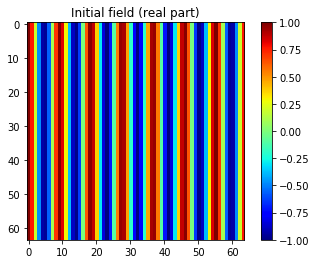

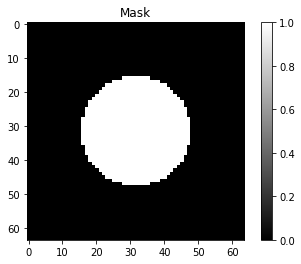

In [78]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.special
import copy


def empty_mask(size):
    return np.zeros((size,size))

def circular_mask(size):
    y,x = np.mgrid[:size, :size]
    M = np.zeros((size,size))
    x0 = y0 = (size-1)/2
    r = size/4
    M[(x-x0)**2+(y-y0)**2<=r**2]=1
    return M

def rectangle_mask(size):
    y,x = np.mgrid[:size, :size]
    M = np.zeros((size,size))
    x0 = y0 = (size-1)/2
    r = size/4
    M[((x-x0)**2<=r**2)*((y-y0)**2<=r**2)]=1
    return M
    

    
def get_plane_wave(E0,k,size):
    y,x = np.mgrid[:size, :size]
    a = np.pi*0/180
    E = E0*np.exp(-1j*k*(x*np.cos(a)+y*np.sin(a)))
    return(E) 
    
def get_greenfun(r,k):
    return (1j/4)*scipy.special.hankel1(0,k*r)

def get_green_matrix(k,size):
    j,i = np.mgrid[:size, :size]
    ij_block = np.sqrt((i-1/2)**2+j**2)
    green_mat = get_greenfun(ij_block,k)
    return green_mat

# def get_toeplitz_mat(ij_block):
#     ij_block = copy.deepcopy(ij_block)
#     T = np.block([[ij_block,ij_block[:,:0:-1]],
#                   [ij_block[:0:-1,:],ij_block[:0:-1,:0:-1]]])
#     return T

def get_toeplitz_mat(ij_block):
    ij_block = copy.deepcopy(ij_block)
    T1 = np.hstack((ij_block,ij_block[:,:0:-1]))
    T2 = np.hstack((ij_block[:0:-1,:],ij_block[:0:-1,:0:-1]))
    T = np.vstack((T1,T2))
    return T
    
def G_matvec(vec,k):
    size = int(np.sqrt(vec.shape[0]))
    G_block = get_green_matrix(k,size)
    G = get_toeplitz_mat(G_block)
    mat = np.zeros((2*size-1,2*size-1),dtype = np.complex64)
    mat_block = vec.reshape((-1,size))
    mat[:size,:size] = mat_block
    out_mat = np.fft.ifft2(np.fft.fft2(G)*np.fft.fft2(mat))
    out = out_mat[:size,:size].reshape((-1,1))
    return out

def get_eps_from_mask(e,mask):
    return (e-1)*mask.reshape((-1,1))+1

def matvec(x,eps,k,e):
    x = x.reshape((-1,1))
    #print(x)
    size = x.shape[0]
    chi = k**2*(eps - 1)
    return x-G_matvec(x*chi,k)

def old_matvec(x,mask,k,e):
    eps = get_eps_from_mask(e,mask)
    return matvec(x,eps,k,e)

def visualize(data,title = "",cmap='jet',):
    plt.title(title)
    neg = plt.imshow(data, cmap=cmap, interpolation='none')
    plt.colorbar(neg)
    plt.show()


    
def solve(E,eps0,eps1):
    return E


size = 64
e = 2.25
k  = 2*np.pi/(size/7)
F = get_plane_wave(1,k,size)
eps = get_eps_from_mask(e,mask)
visualize(F.real,"Initial field (real part)")
#mask = rectangle_mask(size)
mask = circular_mask(size)
visualize(mask,"Mask","gray")



Status: Converged, successful exit


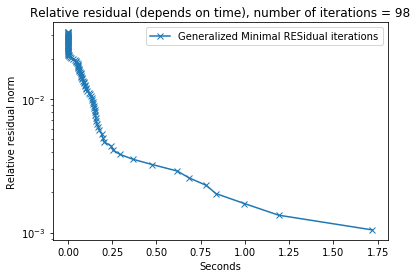

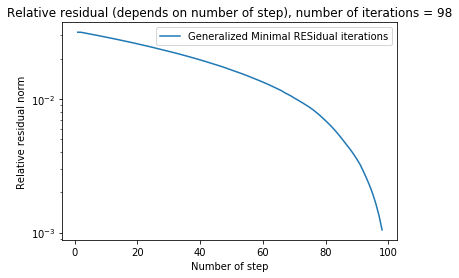

Achieved tolerance =  9.68064623396e-07


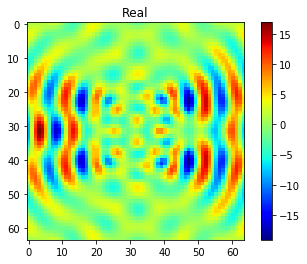

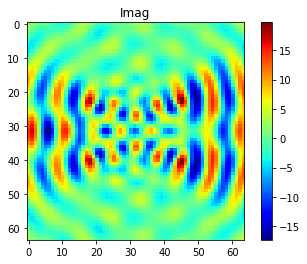

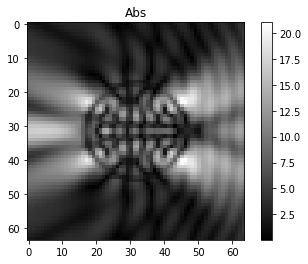

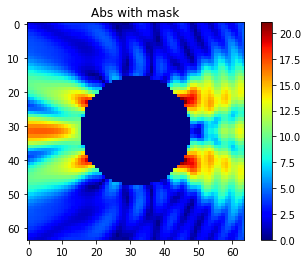

In [81]:
import scipy.sparse.linalg as spla
import inspect
import time

def plot__solution_re_im_abs_mask(solution, size):
    solution_re = solution.real.reshape(-1,size)
    solution_im = solution.imag.reshape(-1,size)
    solution_abs = np.abs(solution).reshape(-1,size)
    solution_abs_mask = np.abs(solution).reshape(-1,size)*(1-mask)
    visualize(solution_re,"Real")
    visualize(solution_im,"Imag")
    visualize(solution_abs,"Abs","gray")
    visualize(solution_abs_mask,"Abs with mask")
    return solution_re, solution_im, solution_abs, solution_abs_mask

def plot_relative_residuals_norms(t, residuals, relative_vector):
    plt.semilogy(t, residuals/np.linalg.norm(relative_vector), 'x-', label="Generalized Minimal RESidual iterations")
    plt.legend()
    plt.title('Relative residual (depends on time), number of iterations = %i' % len(residuals))
    plt.xlabel('Seconds')
    plt.ylabel('Relative residual norm')
    plt.show()
    plt.semilogy(np.arange(len(residuals), 0, -1), residuals/np.linalg.norm(relative_vector), label="Generalized Minimal RESidual iterations")
    plt.legend()
    plt.title('Relative residual (depends on number of step), number of iterations = %i' % len(residuals))
    plt.xlabel('Number of step')    
    plt.ylabel('Relative residual norm')
    plt.show()
    
def gmres_solver(A, b, x0, maxiter, tol, 
                 draw_graph_flag = False, 
                 convergence_info = False, 
                 display_convergence_info = False,
                 display_achieved_tolerance = False):
    gmres_residuals_with_t = []
    t0 = time.time()
    solution, info =  spla.gmres(A, b,  x0=x0, maxiter = maxiter, tol = tol, restart  = max_iter, callback = lambda x:
        gmres_residuals_with_t.append([(inspect.currentframe().f_back).f_locals['resid'], time.time()])
        )
    gmres_residuals_with_t = np.array(gmres_residuals_with_t).T
    gmres_residuals_with_t[1] = gmres_residuals_with_t[1]-t0
    gmres_t, gmres_residuals = gmres_residuals_with_t
    if (display_convergence_info == True):
        if (info == 0):
            print("Status: Converged, successful exit")
        else:
            if (info > 0):
                print("Status: Convergence to tolerance not achieved, number of iterations")
            else:
                print("Status: Illegal input or breakdown")
    if ( draw_graph_flag == True ):
        plot_relative_residuals_norms(gmres_t, gmres_residuals, b)        
    if ( display_achieved_tolerance == True):
        print('Achieved tolerance = ', np.linalg.norm(A.dot(solution.reshape(-1,1))-b)/np.linalg.norm(b))
    if (convergence_info == True):
        return solution, info
    return solution
#initialization
max_iter = 300
toler = 1e-6
A = spla.LinearOperator(shape = (size**2, size**2), matvec = lambda x: matvec(x,eps,k,e))
i = 0
b = get_plane_wave(1,k,size).reshape(-1,1)
x0 = np.ones(size**2).reshape(-1,1)
#----------------------------------
solution, info = gmres_solver(A, b, x0, 
                           maxiter=max_iter, 
                           tol=toler, 
                           draw_graph_flag = True, 
                           convergence_info = True, 
                           display_convergence_info = True,
                           display_achieved_tolerance = True)
solution_re, solution_im, solution_abs, solution_abs_mask = plot__solution_re_im_abs_mask(solution, size)


In [55]:
# import cvxpy as cvx

# size = 2
# k  = 2*np.pi/(size/7)
# F = get_plane_wave(1,k,size)

# x = cvx.Variable(size**2)
# eps = cvx.Variable(size**2)



# # lambda val: matvec2(val,eps,k,e
# obj = cvx.Maximize(cvx.max_entries(x))
# #A = spla.LinearOperator(shape = (size**2, size**2), matvec = lambda val: val)
# print(A.dot([1,1,0,0]))
# costrs = [matvec2(x,eps,k,e)==F]
# prob = cvx.Problem(obj,costrs)
# prob.solve()
# print(prob.value)



In [ ]:
from scipy.optimize import maximize

def objective(eps):
    x = solve(...,eps)
    return np.max(x)

x0 = 
sol = minimize(objective,x0,jac = grad,method="BFGS",numiter = 10)
    